# Imports

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cpu')

Loading data files
==================




In [3]:
%%capture
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -o data.zip

# Vocabulary Class (and Text Preprocessing)

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2  # Count SOS and EOS
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [5]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je ne suis pas egoiste .', 'i m not selfish .']


# LSTM Bahdanau

# Random Sample for Subsequent Runs

A random sample from the 'pairs' list was chosen so that the maximum length of the input and output sequences do not change upon subsequent runs, since we are not allowed to use a for-loop in our code!

In [6]:
# sample = random.choice(pairs)
sample = ['vous me faites rougir .', 'you re making me blush .']
sample

['vous me faites rougir .', 'you re making me blush .']

In [7]:
input_sentence = sample[0]
output_sentence = sample[1]

In [8]:
input_indices = [input_lang.word2index[word] for word in input_sentence.split(' ')]
target_indices = [output_lang.word2index[word] for word in output_sentence.split(' ')]

In [9]:
input_indices, target_indices

([118, 27, 590, 2795, 5], [129, 78, 505, 343, 1655, 4])

We need to Attach <EOS> token to list

In [10]:
input_indices.append(EOS_token)
target_indices.append(EOS_token)

In [11]:
input_indices, target_indices

([118, 27, 590, 2795, 5, 1], [129, 78, 505, 343, 1655, 4, 1])

Then converting input_indicies into tensors

In [12]:
input_tensor = torch.tensor(input_indices, dtype=torch.long, device = device)
output_tensor = torch.tensor(target_indices, dtype=torch.long, device = device)

In [13]:
input_tensor.shape, output_tensor.shape

(torch.Size([6]), torch.Size([7]))

# Dimensions

In [14]:
DIM_IN = input_lang.n_words
DIM_OUT = output_lang.n_words
DIM_HID = 256 # arbitraily chosen! must be same for encoder and decoder!
MAX_LEN_IN = input_tensor.size()[0] # length of the input sequence under consideration
MAX_LEN_OUT = output_tensor.size()[0] # length of the output sequence under consideration

In [15]:
DIM_IN, DIM_OUT, DIM_HID, MAX_LEN_IN, MAX_LEN_OUT

(4345, 2803, 256, 6, 7)

## Printing Function

In [16]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
def plot_func(embedded_input, output, input_word):
  embedded_input_cpu = embedded_input.cpu()
  plt.figure(figsize = (16,16))
  seaborn.heatmap(embedded_input_cpu.detach().numpy().reshape(-1, 16), fmt=".2f",annot=True, cmap="Blues").set(title=f"Embeddings for word => {input_word}")
  plt.xticks([])
  plt.yticks([])
  plt.show()
  output_cpu = output[0,0].cpu()
  plt.figure(figsize = (16,16))
  seaborn.heatmap(output_cpu.detach().numpy().reshape(-1, 16), fmt=".2f",annot=True, cmap="Blues").set(title=f"Encoder hidden state for word => {input_word}")
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print("\n\n")

# Encoder

## Instantiating layers

In [17]:
embedding = nn.Embedding(DIM_IN, DIM_HID).to(device)
lstm = nn.LSTM(DIM_HID, DIM_HID).to(device)

## Feeding Input Sequence to Encoder

In [18]:
encoder_outputs = torch.zeros(MAX_LEN_IN, DIM_HID, device=device) # array to store outputs of enocders so that it can be used for attention
hidden = torch.zeros(1, 1, DIM_HID, device=device) # first hidden state initialized as zeros
cell = torch.zeros(1, 1, DIM_HID, device=device) # first hidden state initialized as zeros

In [19]:
input = input_tensor[0].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[0] += output[0,0]

Step 0
Word => vous

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


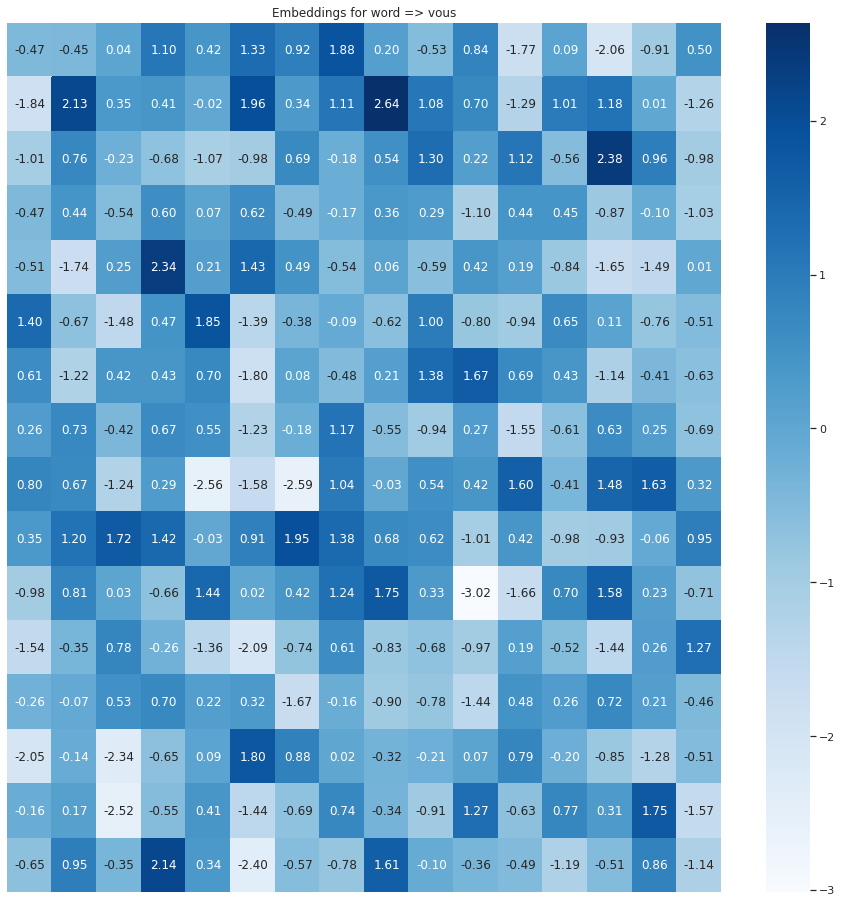

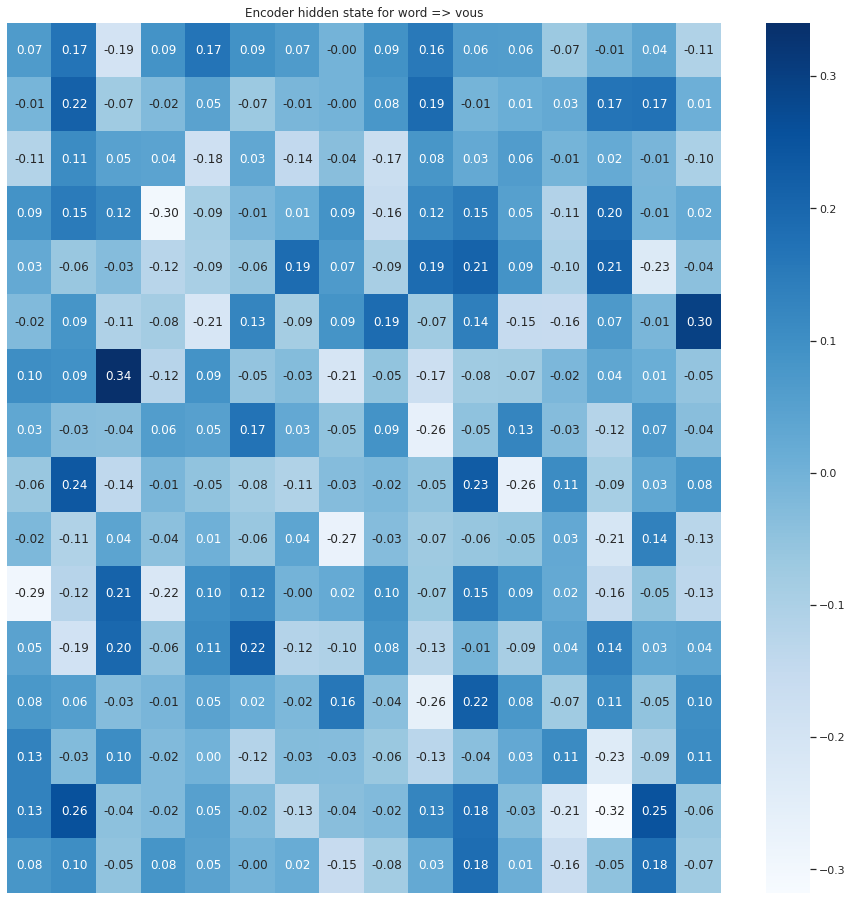

In [20]:
print('Step %d\nWord => %s\n'%(0,input_sentence.split(' ')[0]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[0])

Step 1
Word => me

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


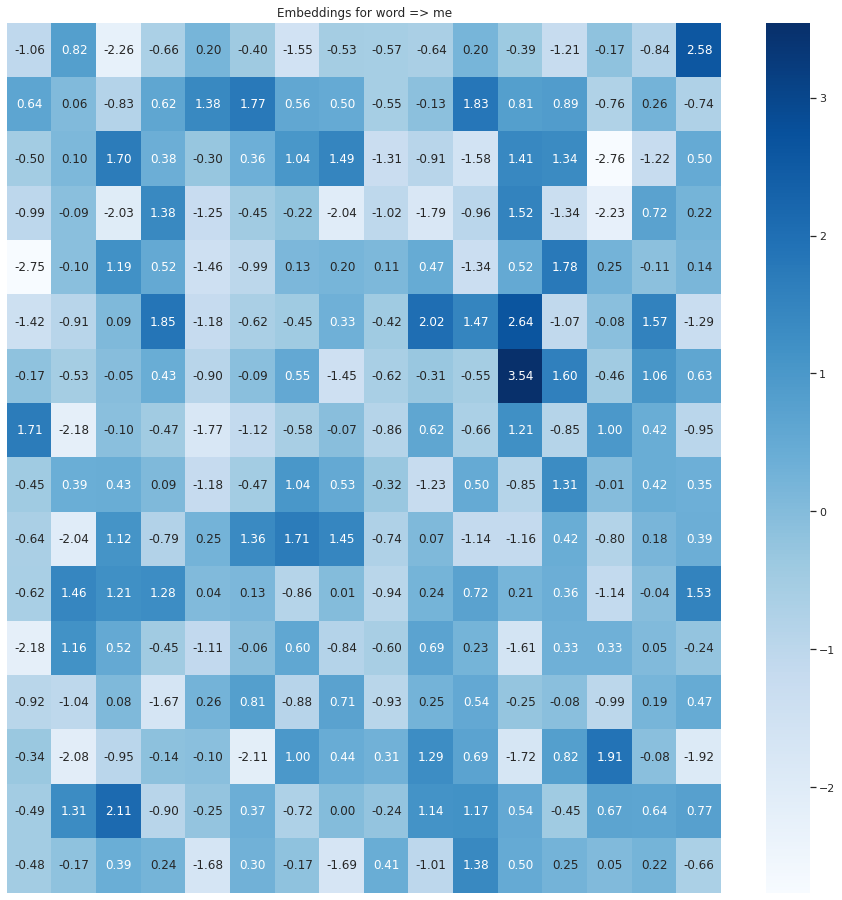

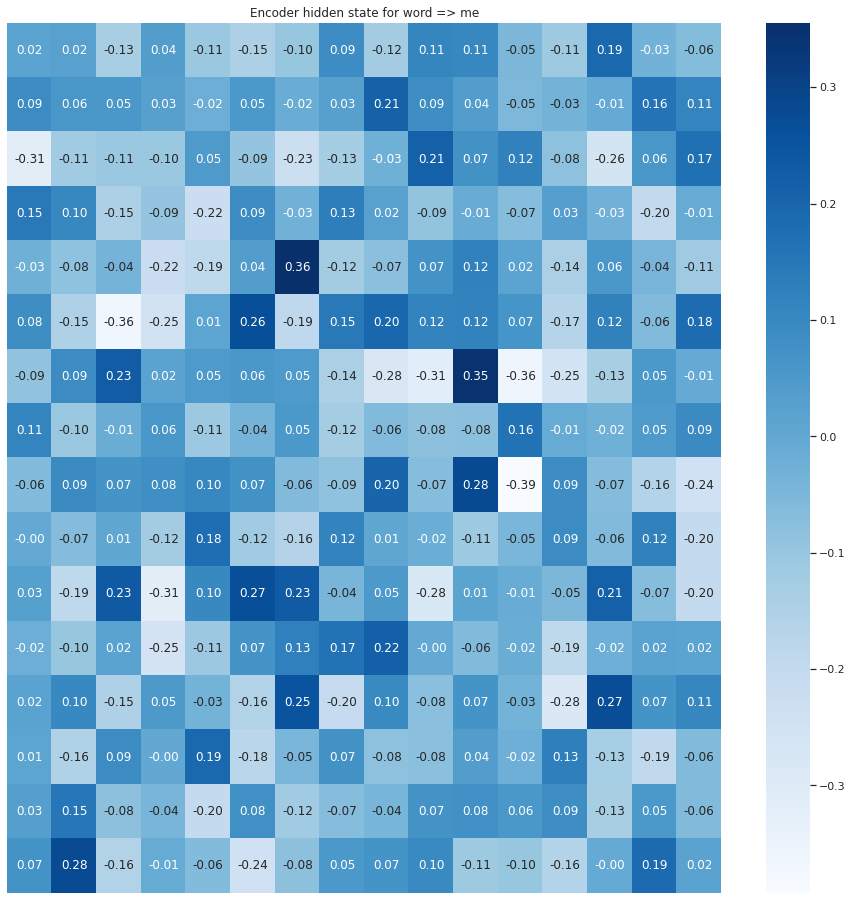

In [21]:
input = input_tensor[1].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[1] += output[0,0]
print('Step %d\nWord => %s\n'%(1,input_sentence.split(' ')[1]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[1])

Step 2
Word => faites

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


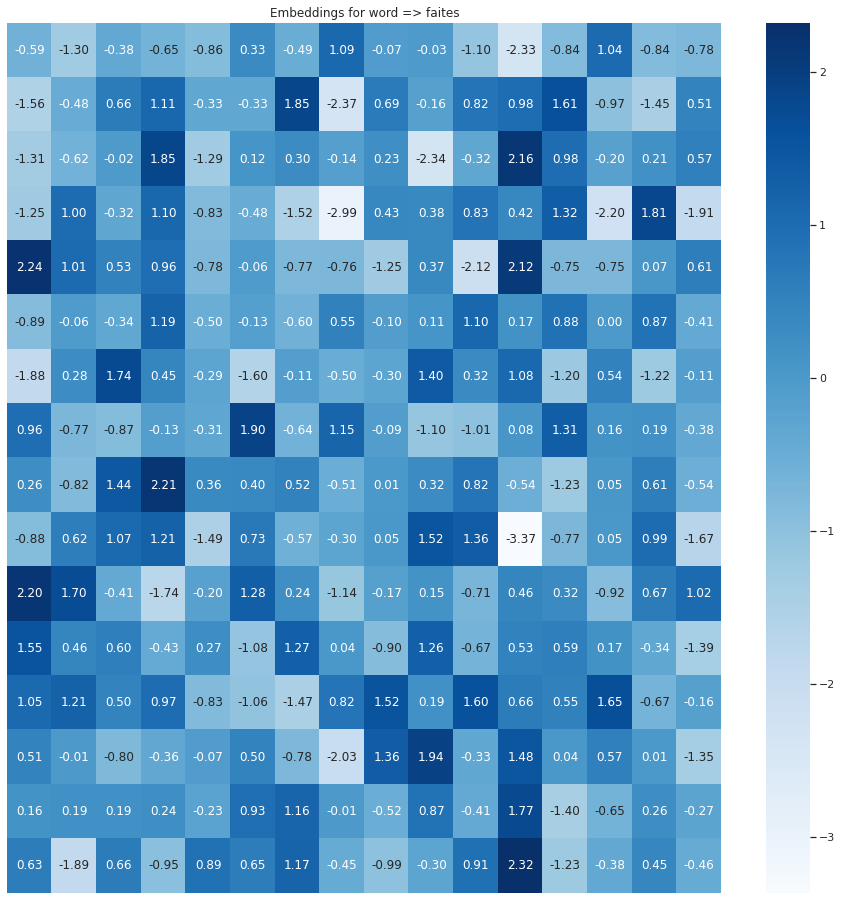

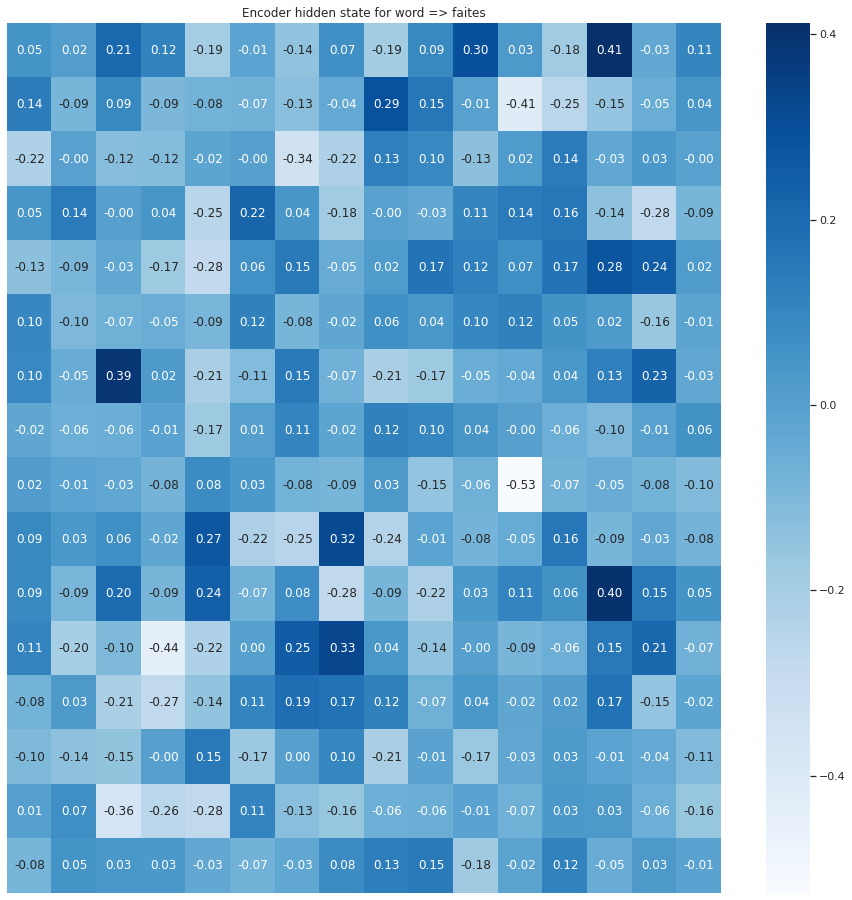

In [22]:
input = input_tensor[2].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[2] += output[0,0]
print('Step %d\nWord => %s\n'%(2,input_sentence.split(' ')[2]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[2])

Step 3
Word => rougir

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


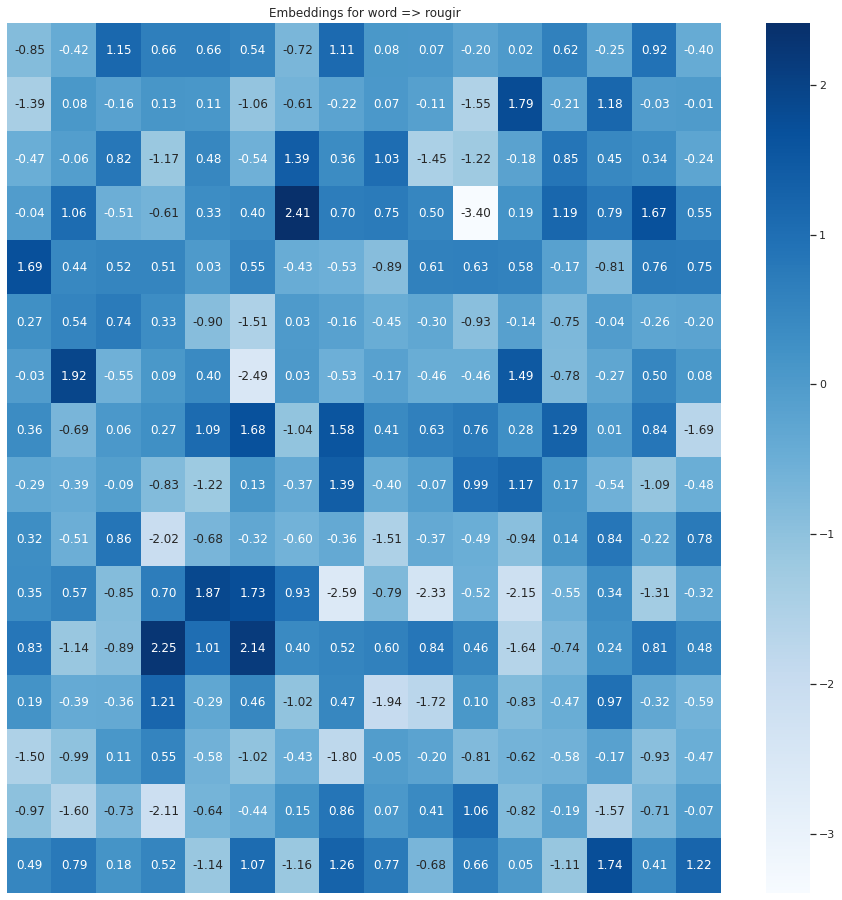

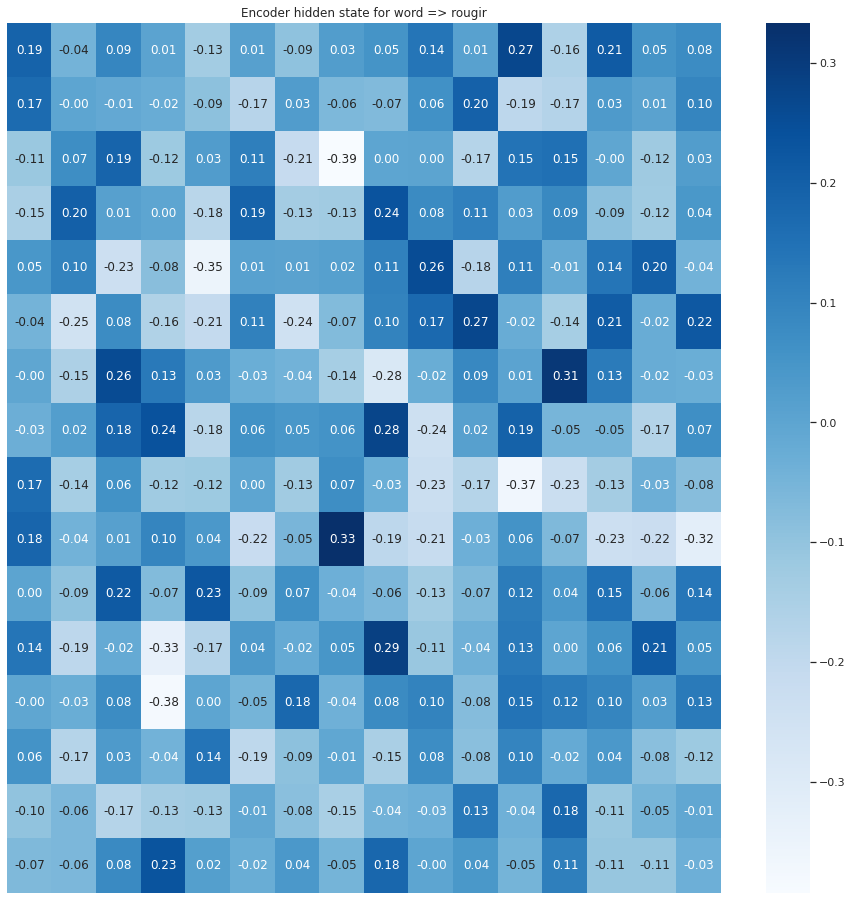

In [23]:
input = input_tensor[3].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[3] += output[0,0]
print('Step %d\nWord => %s\n'%(3,input_sentence.split(' ')[3]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[3])

Step 4
Word => .

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


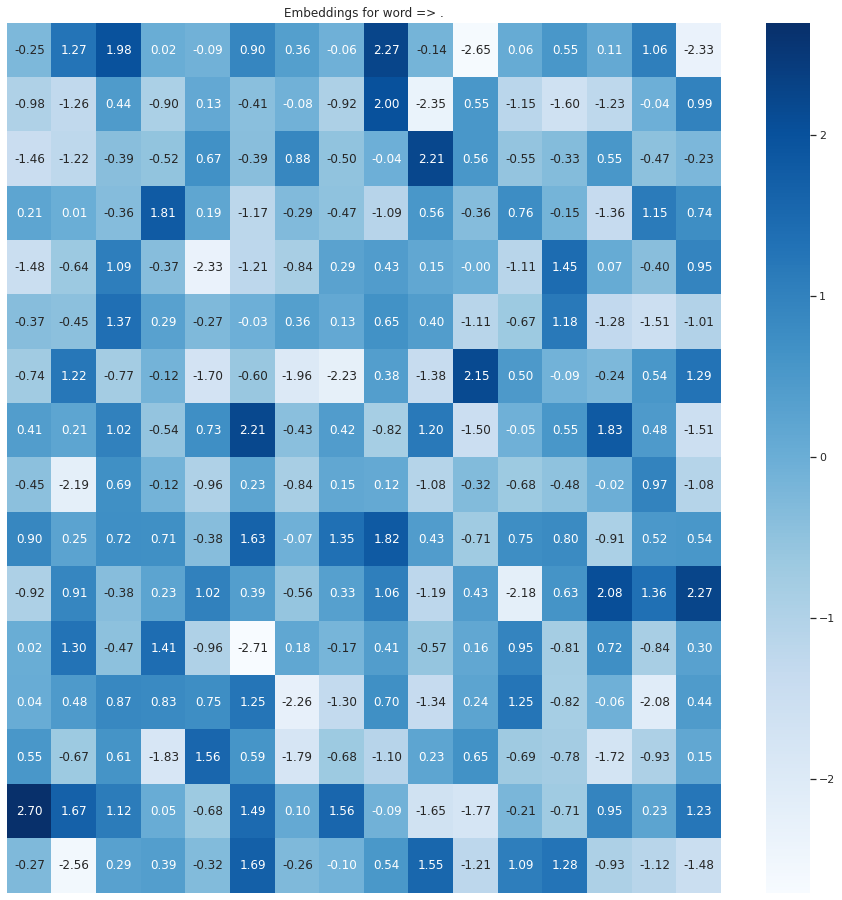

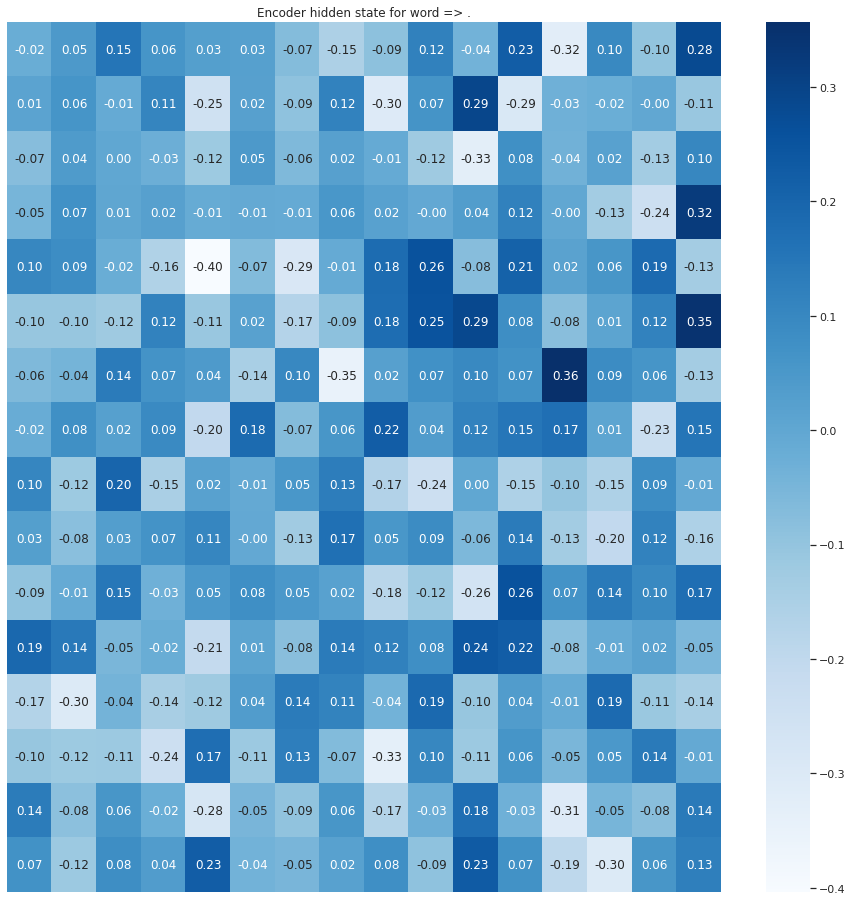

In [24]:
input = input_tensor[4].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[4] += output[0,0]
print('Step %d\nWord => %s\n'%(4,input_sentence.split(' ')[4]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[4])

Step 5
Word => <EOS>

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


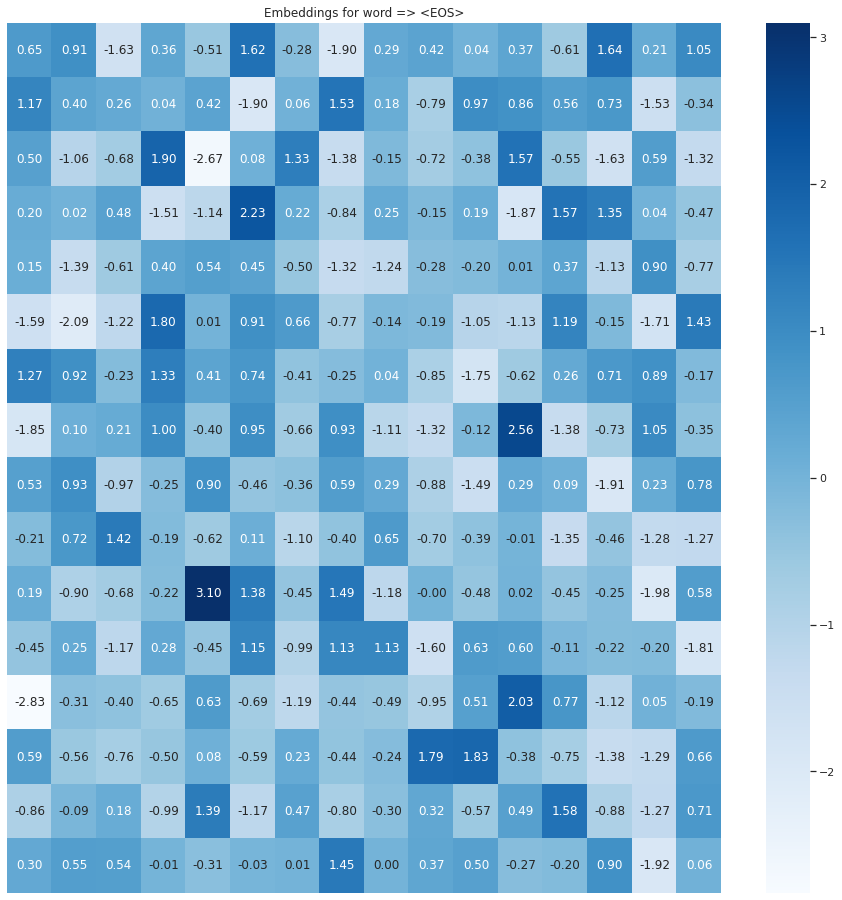

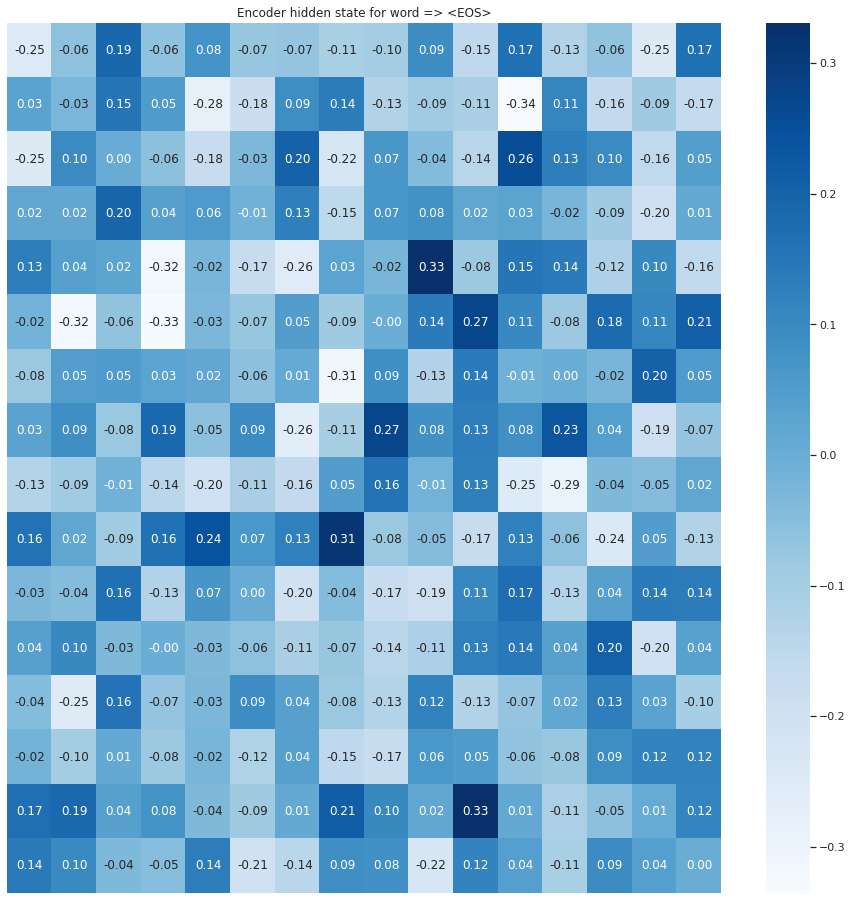

In [25]:
input = input_tensor[5].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[5] += output[0,0]
print('Step %d\nWord => %s\n'%(5,"<EOS>"))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, "<EOS>")

# Decoder

## Instantiating Layers

In [26]:
embedding = nn.Embedding(DIM_OUT, DIM_HID).to(device)
attn = nn.Linear(DIM_HID, DIM_HID)
lstm_inp = nn.Linear(DIM_HID * 2, DIM_HID).to(device) #this layer takes care of the mismatched dimensions
lstm = nn.LSTM(DIM_HID, DIM_HID).to(device)
linear_out = nn.Linear(DIM_HID*2, DIM_OUT).to(device)

In [27]:
predicted_sentence = []

In [28]:
def attention_plot(attn_weights):
  attn_weights_cpu = attn_weights.cpu()
  plt.figure(figsize = (6,1))
  seaborn.heatmap(attn_weights_cpu.detach().numpy().reshape(-1, 6), fmt=".2f",annot=True, cmap="Blues").set(title=f"Attention Weights")
  plt.xticks([])
  plt.yticks([])
  plt.show()

## Feeding to the Decoder - Word 1


Step 0
Expected output(word) => you 
Expected output(Index) => 129 
Decoder Embedding shape torch.Size([1, 1, 256])
Predicted output(word) => absolute 
Predicted output(Index) => 1467 


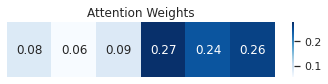

In [29]:
decoder_input = torch.tensor([[SOS_token]], device=device) # We start from the <SOS> Token
decoder_hidden = hidden # what we got from the output of the encoder from the last word
decoder_cell = cell # what we got from the output of the encoder from the last word
print('\nStep %d'%(0))
print('Expected output(word) => %s '% output_sentence.split(" ")[0])
print('Expected output(Index) => %d '% target_indices[0])
embedded = embedding(decoder_input)
print('Decoder Embedding shape',embedded.shape)
## Attn module
attn_energies = torch.zeros(MAX_LEN_IN).to(device)
for i in range(MAX_LEN_IN):
  energy = attn(encoder_outputs[i])
  attn_energies[i] = hidden[0,0].dot(energy) + cell[0,0].dot(energy)
attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)
##

context = attn_weights.bmm(encoder_outputs.unsqueeze(1).transpose(0, 1))

input_to_lstm1 = torch.cat((embedded, context), 2)
input_to_lstm2 = lstm_inp(input_to_lstm1)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm2, (decoder_hidden, decoder_cell))

output = F.log_softmax(linear_out(torch.cat((output, context), 2)), dim=2)
top_value, top_index = output.data.topk(1) # same as using np.argmax

out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 2

In [30]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 1
Expected output(word) => re 
Expected output(Index) => 78 
Predicted output(word) => concerns 
Predicted output(Index) => 2549 


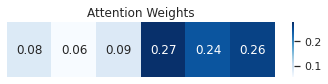

In [31]:
embedded = embedding(decoder_input)
print('\nStep %d'%(1))
print('Expected output(word) => %s '% output_sentence.split(" ")[1])
print('Expected output(Index) => %d '% target_indices[1])
## Attn module
attn_energies = torch.zeros(MAX_LEN_IN).to(device)
for i in range(MAX_LEN_IN):
  energy = attn(encoder_outputs[i])
  attn_energies[i] = hidden[0,0].dot(energy) + cell[0,0].dot(energy)
attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)
##

context = attn_weights.bmm(encoder_outputs.unsqueeze(1).transpose(0, 1))

input_to_lstm1 = torch.cat((embedded, context), 2)
input_to_lstm2 = lstm_inp(input_to_lstm1)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm2, (decoder_hidden, decoder_cell))

output = F.log_softmax(linear_out(torch.cat((output, context), 2)), dim=2)
top_value, top_index = output.data.topk(1) # same as using np.argmax

out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 3

In [32]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 2
Expected output(word) => making 
Expected output(Index) => 505 
Predicted output(word) => mobile 
Predicted output(Index) => 2642 


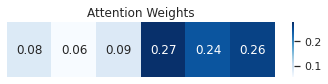

In [33]:
embedded = embedding(decoder_input)
print('\nStep %d'%(2))
print('Expected output(word) => %s '% output_sentence.split(" ")[2])
print('Expected output(Index) => %d '% target_indices[2])
## Attn module
attn_energies = torch.zeros(MAX_LEN_IN).to(device)
for i in range(MAX_LEN_IN):
  energy = attn(encoder_outputs[i])
  attn_energies[i] = hidden[0,0].dot(energy) + cell[0,0].dot(energy)
attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)
##

context = attn_weights.bmm(encoder_outputs.unsqueeze(1).transpose(0, 1))

input_to_lstm1 = torch.cat((embedded, context), 2)
input_to_lstm2 = lstm_inp(input_to_lstm1)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm2, (decoder_hidden, decoder_cell))

output = F.log_softmax(linear_out(torch.cat((output, context), 2)), dim=2)
top_value, top_index = output.data.topk(1) # same as using np.argmax

out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 4

In [34]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 3
Expected output(word) => me 
Expected output(Index) => 343 
Predicted output(word) => volunteering 
Predicted output(Index) => 800 


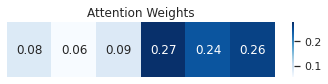

In [35]:
embedded = embedding(decoder_input)
print('\nStep %d'%(3))
print('Expected output(word) => %s '% output_sentence.split(" ")[3])
print('Expected output(Index) => %d '% target_indices[3])
## Attn module
attn_energies = torch.zeros(MAX_LEN_IN).to(device)
for i in range(MAX_LEN_IN):
  energy = attn(encoder_outputs[i])
  attn_energies[i] = hidden[0,0].dot(energy) + cell[0,0].dot(energy)
attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)
##

context = attn_weights.bmm(encoder_outputs.unsqueeze(1).transpose(0, 1))

input_to_lstm1 = torch.cat((embedded, context), 2)
input_to_lstm2 = lstm_inp(input_to_lstm1)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm2, (decoder_hidden, decoder_cell))

output = F.log_softmax(linear_out(torch.cat((output, context), 2)), dim=2)
top_value, top_index = output.data.topk(1) # same as using np.argmax

out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 5

In [36]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 4
Expected output(word) => blush 
Expected output(Index) => 1655 
Predicted output(word) => volunteering 
Predicted output(Index) => 800 


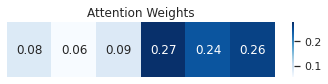

In [37]:
embedded = embedding(decoder_input)
print('\nStep %d'%(4))
print('Expected output(word) => %s '% output_sentence.split(" ")[4])
print('Expected output(Index) => %d '% target_indices[4])
## Attn module
attn_energies = torch.zeros(MAX_LEN_IN).to(device)
for i in range(MAX_LEN_IN):
  energy = attn(encoder_outputs[i])
  attn_energies[i] = hidden[0,0].dot(energy) + cell[0,0].dot(energy)
attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)
##

context = attn_weights.bmm(encoder_outputs.unsqueeze(1).transpose(0, 1))

input_to_lstm1 = torch.cat((embedded, context), 2)
input_to_lstm2 = lstm_inp(input_to_lstm1)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm2, (decoder_hidden, decoder_cell))

output = F.log_softmax(linear_out(torch.cat((output, context), 2)), dim=2)
top_value, top_index = output.data.topk(1) # same as using np.argmax

out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 6

In [38]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 5
Expected output(word) => . 
Expected output(Index) => 4 
Predicted output(word) => situation 
Predicted output(Index) => 2227 


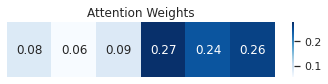

In [39]:
embedded = embedding(decoder_input)
print('\nStep %d'%(5))
print('Expected output(word) => %s '% output_sentence.split(" ")[5])
print('Expected output(Index) => %d '% target_indices[5])
## Attn module
attn_energies = torch.zeros(MAX_LEN_IN).to(device)
for i in range(MAX_LEN_IN):
  energy = attn(encoder_outputs[i])
  attn_energies[i] = hidden[0,0].dot(energy) + cell[0,0].dot(energy)
attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)
##

context = attn_weights.bmm(encoder_outputs.unsqueeze(1).transpose(0, 1))

input_to_lstm1 = torch.cat((embedded, context), 2)
input_to_lstm2 = lstm_inp(input_to_lstm1)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm2, (decoder_hidden, decoder_cell))

output = F.log_softmax(linear_out(torch.cat((output, context), 2)), dim=2)
top_value, top_index = output.data.topk(1) # same as using np.argmax

out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 7

In [40]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 6
Expected output(word) => <EOS> 
Expected output(Index) => 1 
Predicted output(word) => mobile 
Predicted output(Index) => 2642 


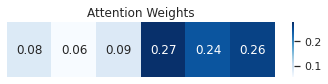

In [41]:
embedded = embedding(decoder_input)
print('\nStep %d'%(6))
print('Expected output(word) => %s '% "<EOS>")
print('Expected output(Index) => %d '% target_indices[6])
## Attn module
attn_energies = torch.zeros(MAX_LEN_IN).to(device)
for i in range(MAX_LEN_IN):
  energy = attn(encoder_outputs[i])
  attn_energies[i] = hidden[0,0].dot(energy) + cell[0,0].dot(energy)
attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)
##

context = attn_weights.bmm(encoder_outputs.unsqueeze(1).transpose(0, 1))

input_to_lstm1 = torch.cat((embedded, context), 2)
input_to_lstm2 = lstm_inp(input_to_lstm1)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm2, (decoder_hidden, decoder_cell))

output = F.log_softmax(linear_out(torch.cat((output, context), 2)), dim=2)
top_value, top_index = output.data.topk(1) # same as using np.argmax

out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

In [42]:
predicted_sentence = ' '.join(predicted_sentence)
predicted_sentence

'absolute concerns mobile volunteering volunteering situation mobile'

# LSTM only

# Random Sample for Subsequent Runs

A random sample from the 'pairs' list was chosen so that the maximum length of the input and output sequences do not change upon subsequent runs, since we are not allowed to use a for-loop in our code!

In [43]:
# sample = random.choice(pairs)
sample = ['vous me faites rougir .', 'you re making me blush .']
sample

['vous me faites rougir .', 'you re making me blush .']

In [44]:
input_sentence = sample[0]
output_sentence = sample[1]

In [45]:
input_indices = [input_lang.word2index[word] for word in input_sentence.split(' ')]
target_indices = [output_lang.word2index[word] for word in output_sentence.split(' ')]

In [46]:
input_indices.append(EOS_token)
target_indices.append(EOS_token)

In [47]:
input_indices, target_indices

([118, 27, 590, 2795, 5, 1], [129, 78, 505, 343, 1655, 4, 1])

In [48]:
input_tensor = torch.tensor(input_indices, dtype=torch.long, device = device)
output_tensor = torch.tensor(target_indices, dtype=torch.long, device = device)

In [49]:
input_tensor.shape, output_tensor.shape

(torch.Size([6]), torch.Size([7]))

# Dimensions

In [50]:
DIM_IN = input_lang.n_words
DIM_OUT = output_lang.n_words
DIM_HID = 256 # arbitraily chosen! must be same for encoder and decoder!
MAX_LEN_IN = input_tensor.size()[0] # length of the input sequence under consideration
MAX_LEN_OUT = output_tensor.size()[0] # length of the output sequence under consideration

In [51]:
DIM_IN, DIM_OUT, DIM_HID, MAX_LEN_IN, MAX_LEN_OUT

(4345, 2803, 256, 6, 7)

# Encoder

## Instantiating layers

In [52]:
embedding = nn.Embedding(DIM_IN, DIM_HID).to(device)
lstm = nn.LSTM(DIM_HID, DIM_HID).to(device)

## Feeding Input Sequence to Encoder

In [53]:
encoder_outputs = torch.zeros(MAX_LEN_IN, DIM_HID, device=device) # array to store outputs of enocders so that it can be used for attention
hidden = torch.zeros(1, 1, DIM_HID, device=device) # first hidden state initialized as zeros
cell = torch.zeros(1, 1, DIM_HID, device=device) # first hidden state initialized as zeros

Step 0
Word => vous

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


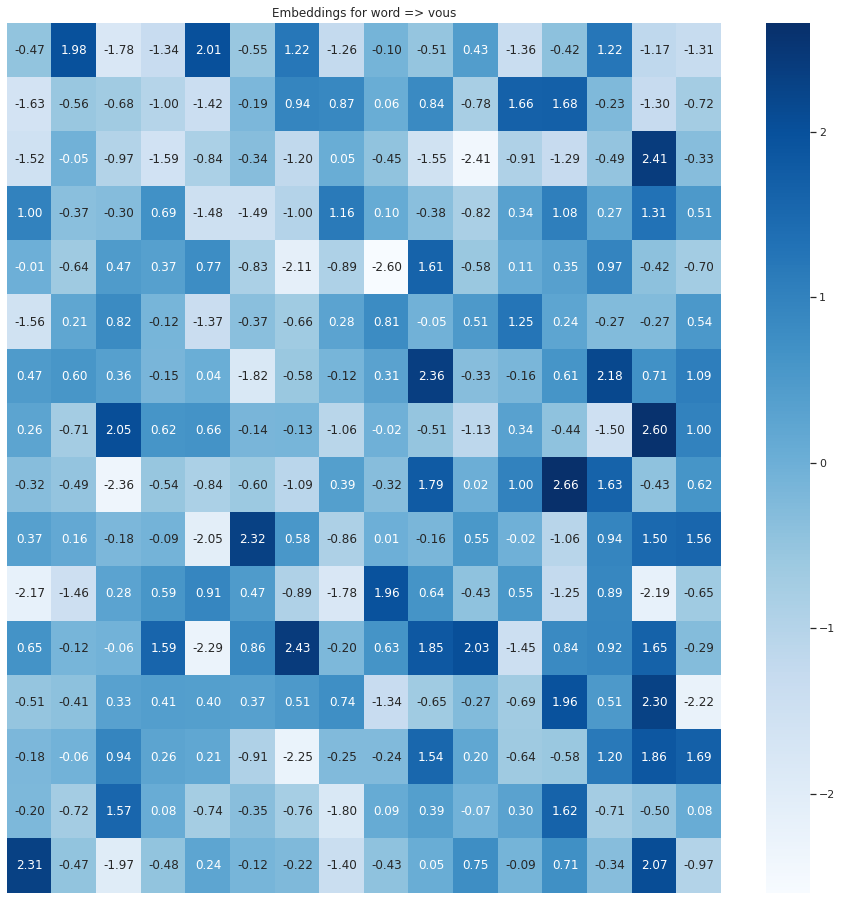

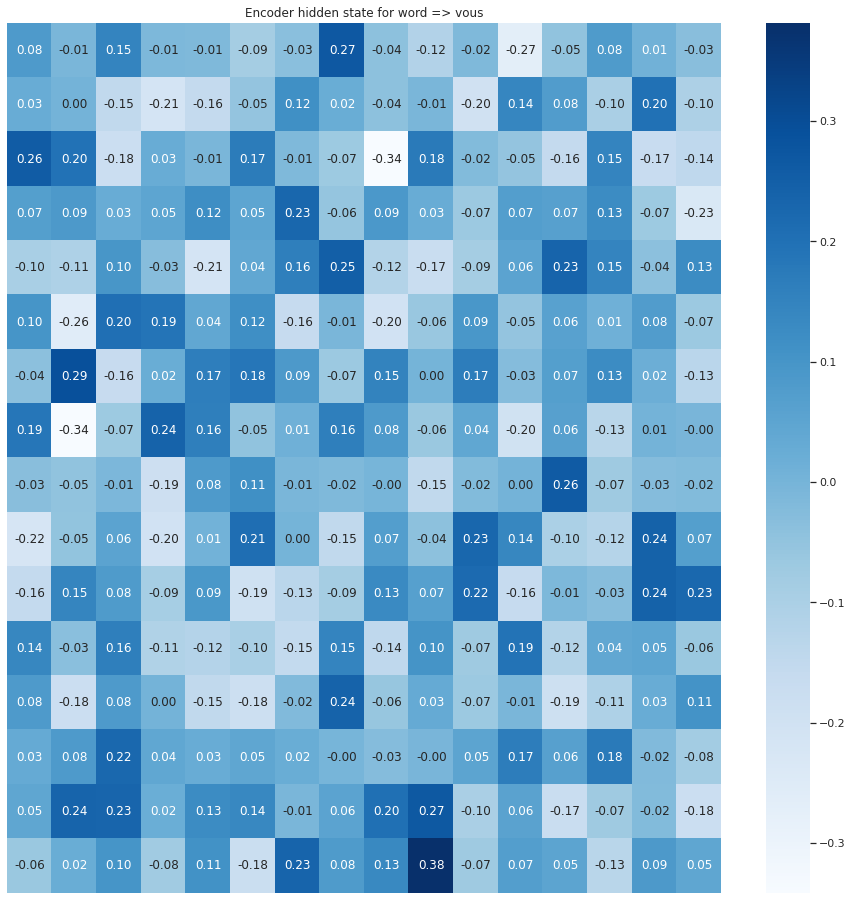

In [54]:
input = input_tensor[0].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[0] += output[0,0]
print('Step %d\nWord => %s\n'%(0,input_sentence.split(' ')[0]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[0])

Step 1
Word => me

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


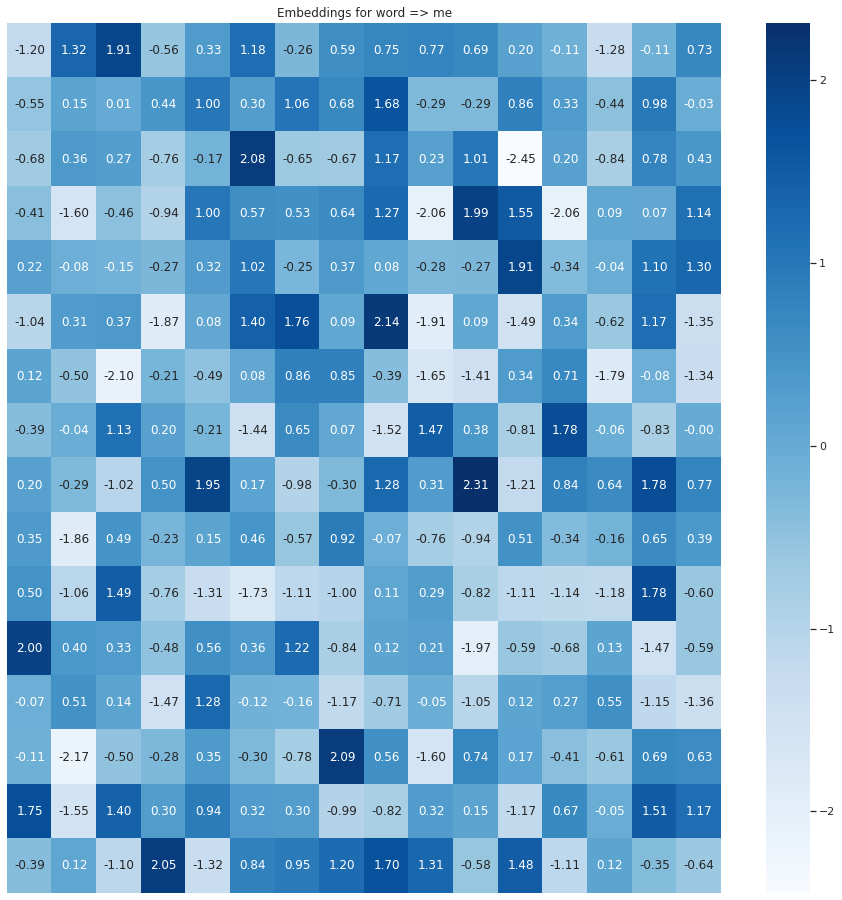

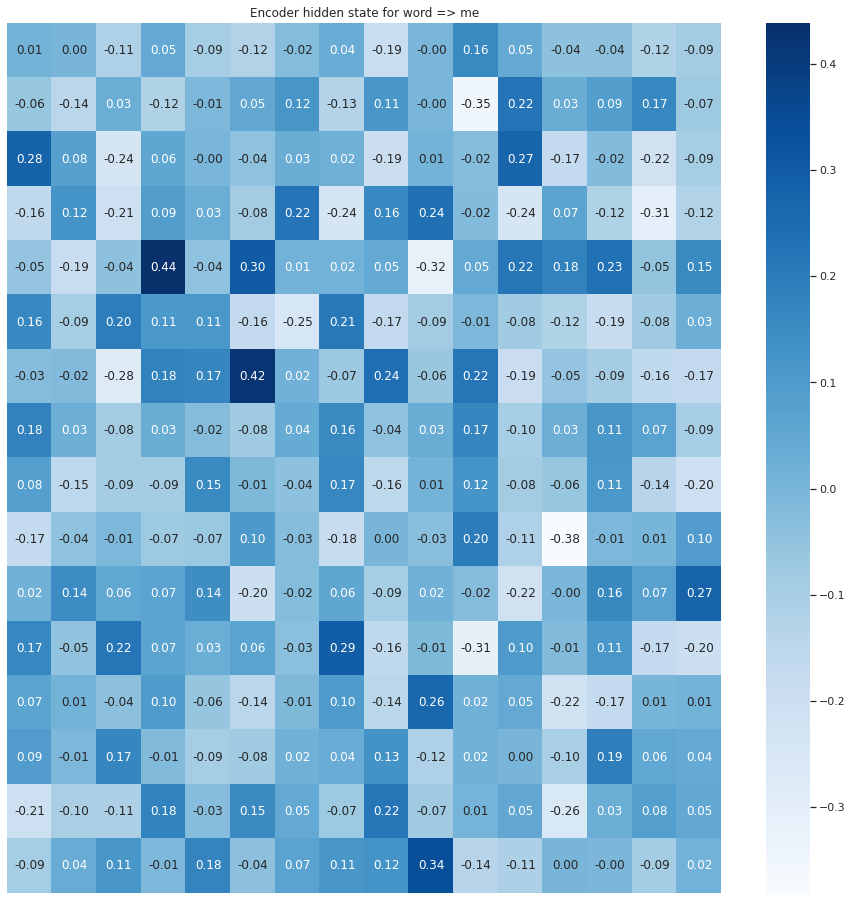

In [55]:
input = input_tensor[1].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[1] += output[0,0]
print('Step %d\nWord => %s\n'%(1,input_sentence.split(' ')[1]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[1])

Step 2
Word => faites

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


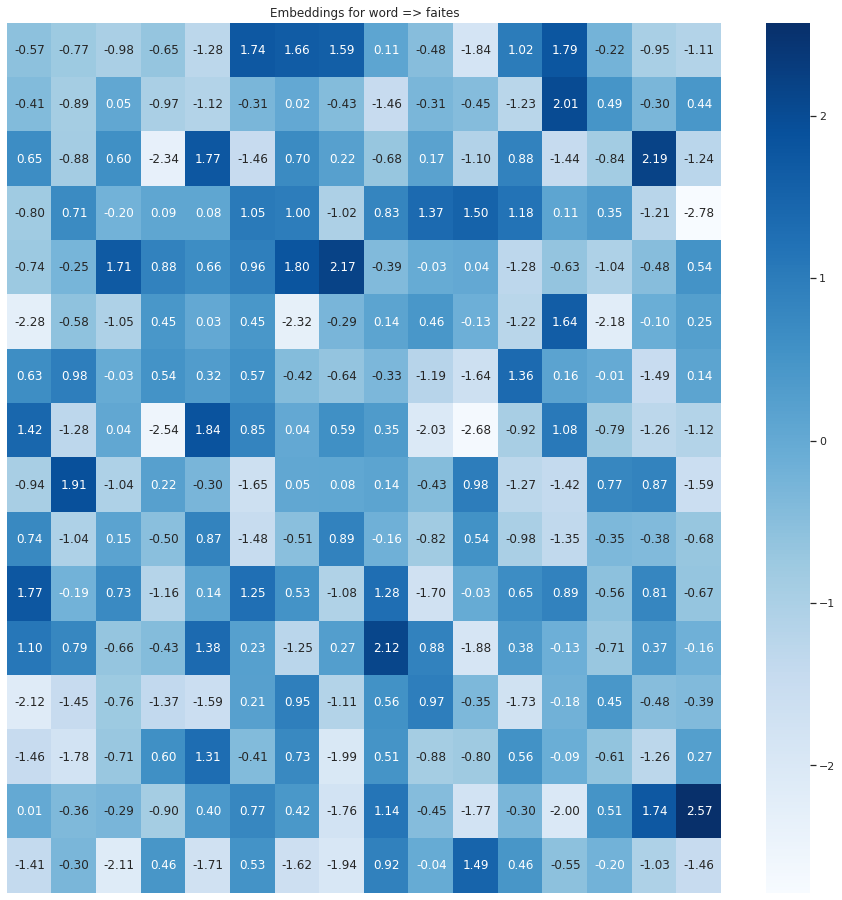

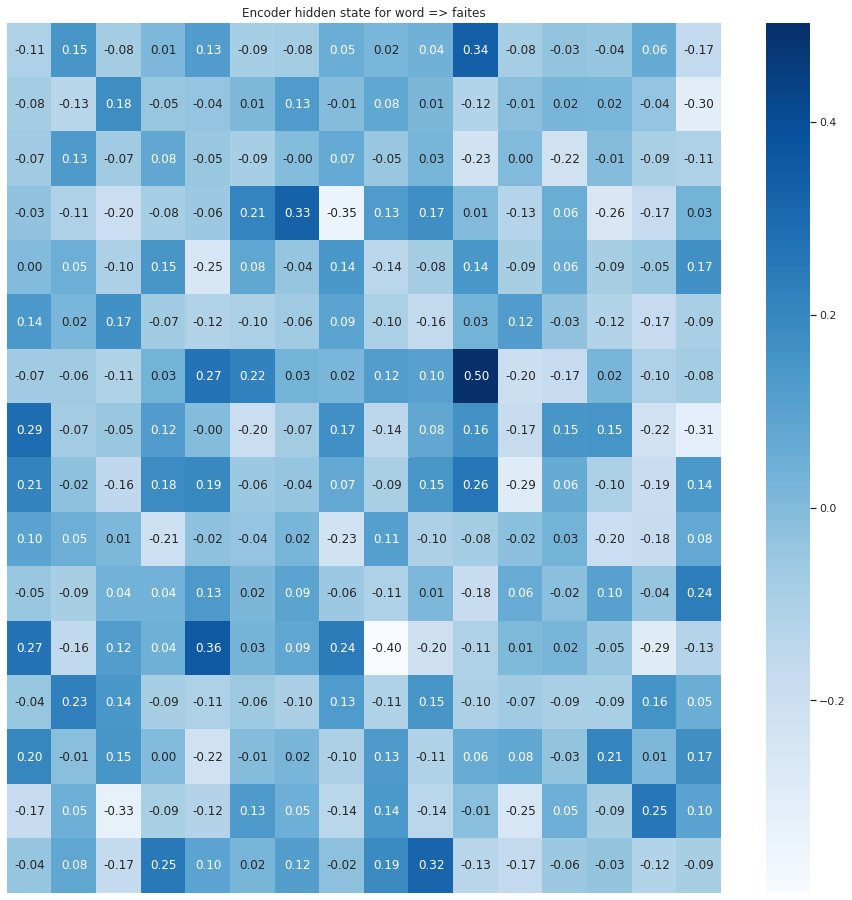

In [56]:
input = input_tensor[2].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[2] += output[0,0]
print('Step %d\nWord => %s\n'%(2,input_sentence.split(' ')[2]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[2])

Step 3
Word => rougir

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


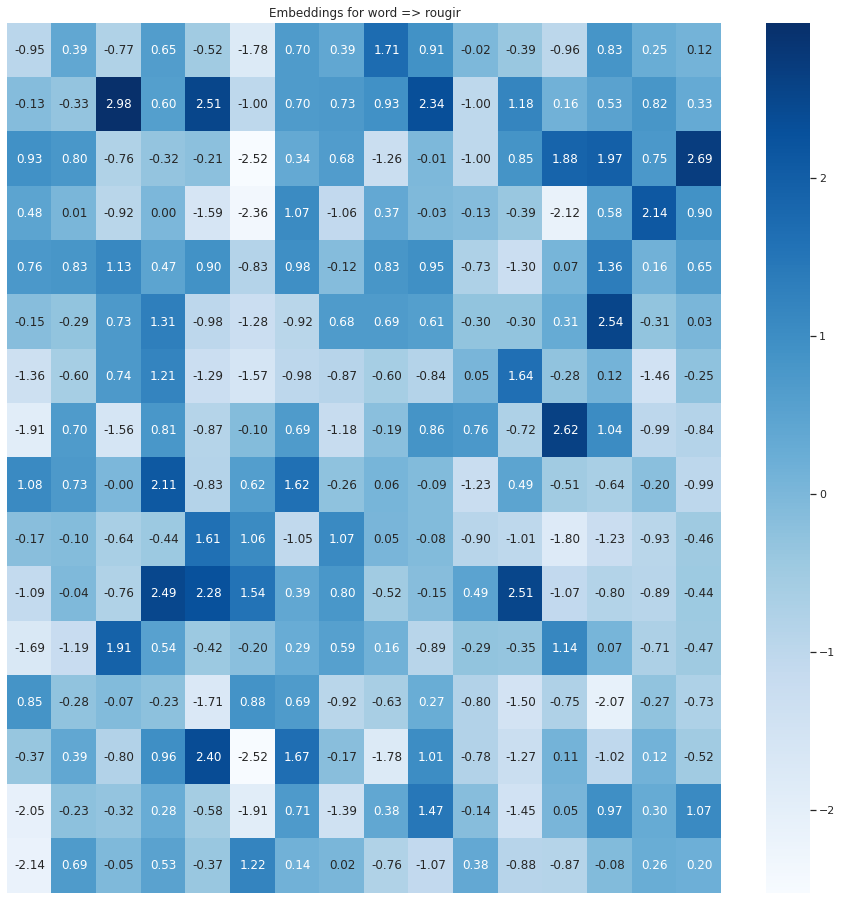

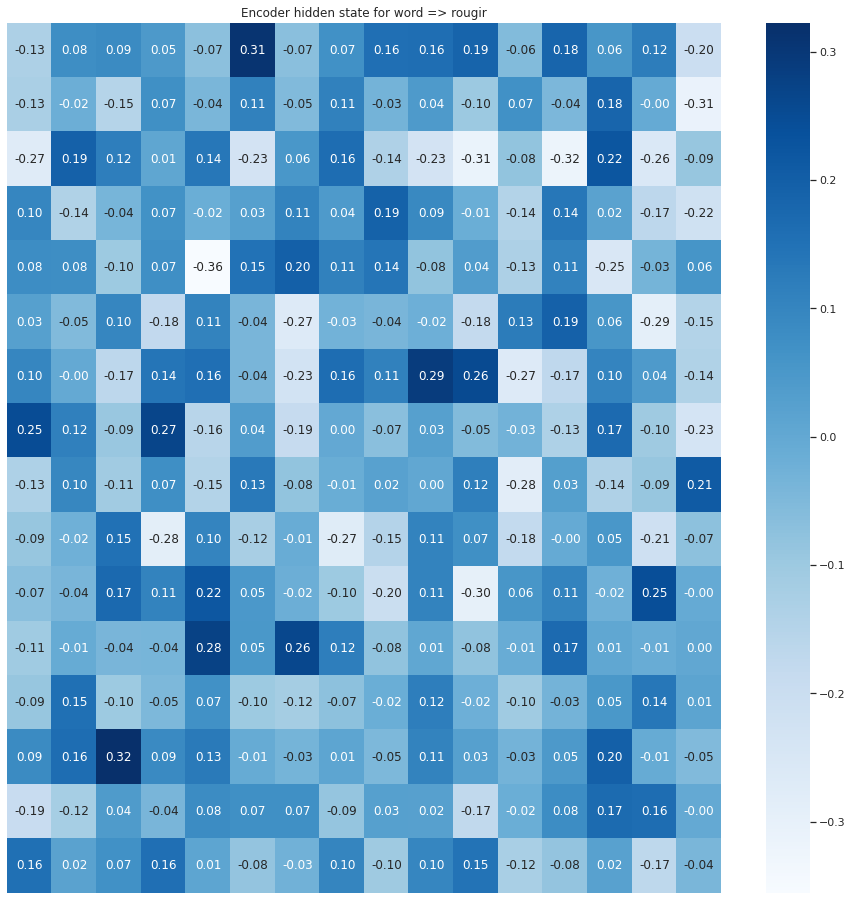

In [57]:
input = input_tensor[3].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[3] += output[0,0]
print('Step %d\nWord => %s\n'%(3,input_sentence.split(' ')[3]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[3])

Step 4
Word => .

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


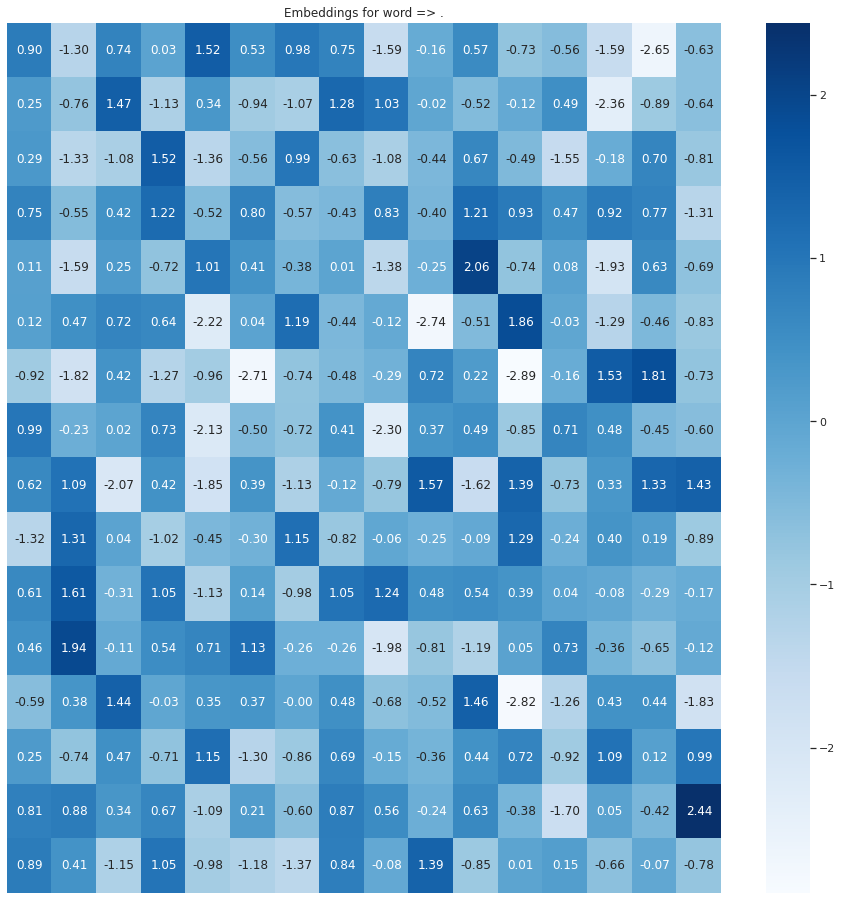

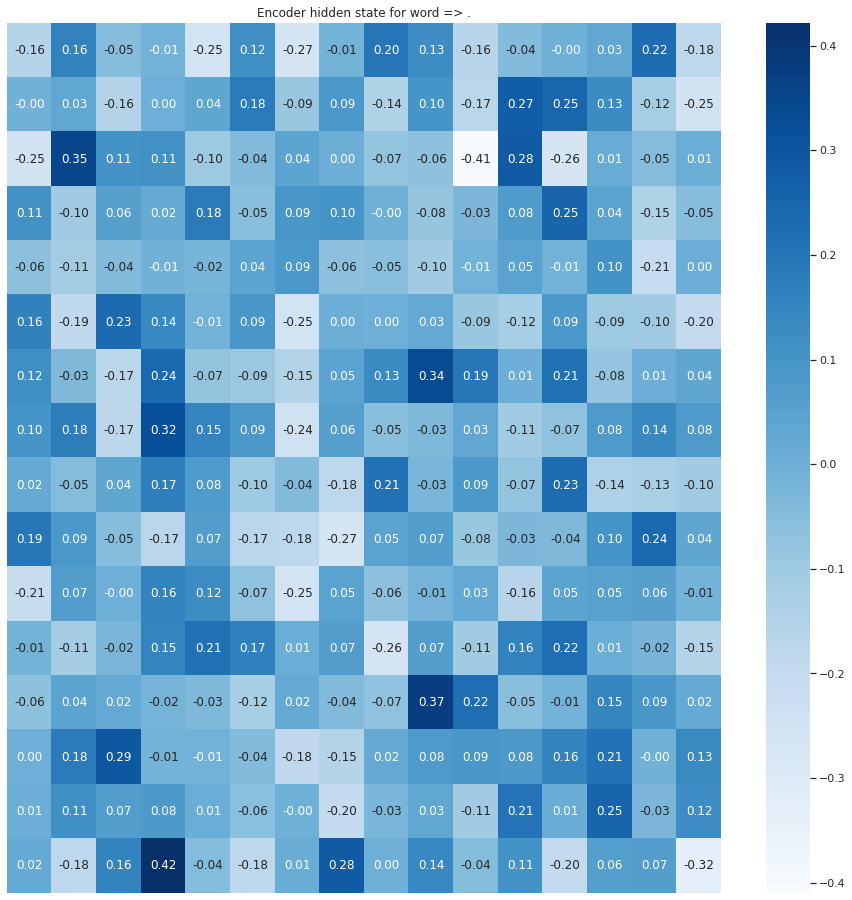

In [58]:
input = input_tensor[4].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[4] += output[0,0]
print('Step %d\nWord => %s\n'%(4,input_sentence.split(' ')[4]))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, input_sentence.split(' ')[4])

Step 5
Word => <EOS>

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])


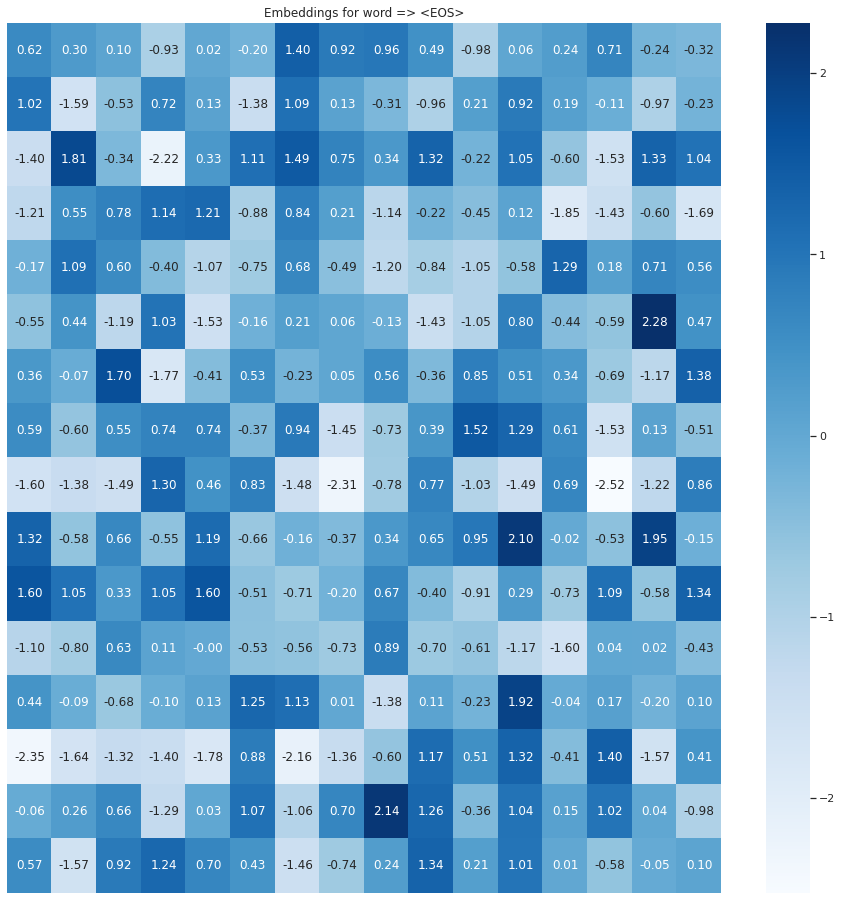

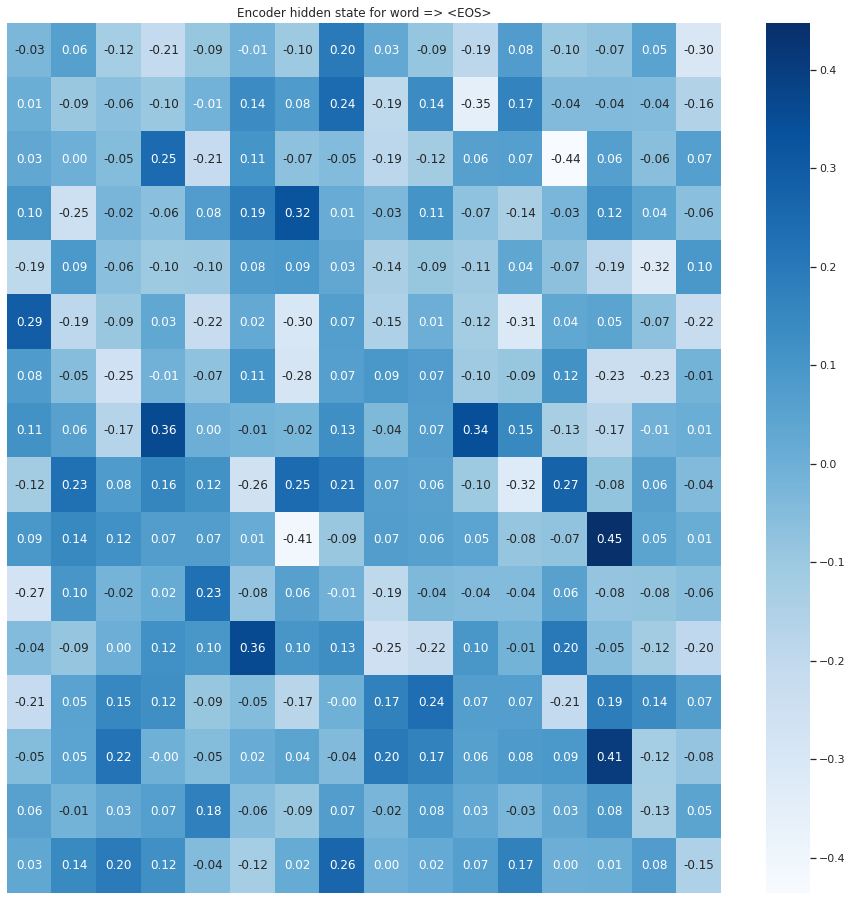

In [59]:
input = input_tensor[5].view(-1, 1)
embedded_input = embedding(input)
output, (hidden, cell) = lstm(embedded_input, (hidden, cell))
encoder_outputs[5] += output[0,0]
print('Step %d\nWord => %s\n'%(5,"<EOS>"))
print(embedded_input.shape, output.shape,hidden.shape,cell.shape)
plot_func(embedded_input, output, "<EOS>")

# Decoder

## Instantiating Layers

In [60]:
embedding = nn.Embedding(DIM_OUT, DIM_HID).to(device)
attn_weigts_layer = nn.Linear(DIM_HID * 3, MAX_LEN_IN).to(device) # The output and hidden layer will be concatenated

lstm_inp = nn.Linear(DIM_HID * 2, DIM_HID).to(device) #this layer takes care of the mismatched dimensions
lstm = nn.LSTM(DIM_HID, DIM_HID).to(device)

linear_out = nn.Linear(DIM_HID, DIM_OUT).to(device)

In [61]:
predicted_sentence = []

## Feeding to the Decoder - Word 1


Step 0
Expected output(word) => you 
Expected output(Index) => 129 
Predicted output(word) => depth 
Predicted output(Index) => 2736 


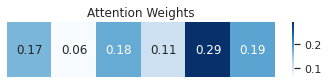

In [62]:
decoder_input = torch.tensor([[SOS_token]], device=device) # We start from the <SOS> Token
decoder_hidden = hidden # what we got from the output of the encoder from the last word
decoder_cell = cell # what we got from the output of the encoder from the last word

embedded = embedding(decoder_input)
print('\nStep %d'%(0))
print('Expected output(word) => %s '% output_sentence.split(" ")[0])
print('Expected output(Index) => %d '% target_indices[0])
# This decides the values with which output from the encoder needs weighed!
attn_weigts_layer_input = torch.cat((embedded[0], decoder_hidden[0], cell[0]), 1)
attn_weights = attn_weigts_layer(attn_weigts_layer_input)
attn_weights = F.softmax(attn_weights, dim = 1)

# This calculates the attention values!
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = lstm_inp(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm, (decoder_hidden, decoder_cell))
output = F.relu(output)

output = F.softmax(linear_out(output[0]), dim = 1)
top_value, top_index = output.data.topk(1) # same as using np.argmax
out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 2

In [63]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 1
Expected output(word) => re 
Expected output(Index) => 78 
Predicted output(word) => desk 
Predicted output(Index) => 851 


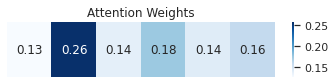

In [64]:
embedded = embedding(decoder_input)
print('\nStep %d'%(1))
print('Expected output(word) => %s '% output_sentence.split(" ")[1])
print('Expected output(Index) => %d '% target_indices[1])
# This decides the values with which output from the encoder needs weighed!
attn_weigts_layer_input = torch.cat((embedded[0], decoder_hidden[0], cell[0]), 1)
attn_weights = attn_weigts_layer(attn_weigts_layer_input)
attn_weights = F.softmax(attn_weights, dim = 1)

# This calculates the attention values!
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = lstm_inp(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm, (decoder_hidden, decoder_cell))
output = F.relu(output)

output = F.softmax(linear_out(output[0]), dim = 1)
top_value, top_index = output.data.topk(1) # same as using np.argmax
out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 3

In [65]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 2
Expected output(word) => making 
Expected output(Index) => 505 
Predicted output(word) => desk 
Predicted output(Index) => 851 


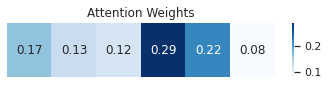

In [66]:
embedded = embedding(decoder_input)
print('\nStep %d'%(2))
print('Expected output(word) => %s '% output_sentence.split(" ")[2])
print('Expected output(Index) => %d '% target_indices[2])
# This decides the values with which output from the encoder needs weighed!
attn_weigts_layer_input = torch.cat((embedded[0], decoder_hidden[0], cell[0]), 1)
attn_weights = attn_weigts_layer(attn_weigts_layer_input)
attn_weights = F.softmax(attn_weights, dim = 1)

# This calculates the attention values!
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = lstm_inp(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm, (decoder_hidden, decoder_cell))
output = F.relu(output)

output = F.softmax(linear_out(output[0]), dim = 1)
top_value, top_index = output.data.topk(1) # same as using np.argmax
out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 4

In [67]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 3
Expected output(word) => me 
Expected output(Index) => 343 
Predicted output(word) => desk 
Predicted output(Index) => 851 


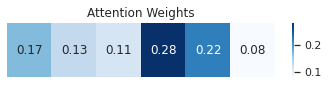

In [68]:
embedded = embedding(decoder_input)
print('\nStep %d'%(3))
print('Expected output(word) => %s '% output_sentence.split(" ")[3])
print('Expected output(Index) => %d '% target_indices[3])
# This decides the values with which output from the encoder needs weighed!
attn_weigts_layer_input = torch.cat((embedded[0], decoder_hidden[0], cell[0]), 1)
attn_weights = attn_weigts_layer(attn_weigts_layer_input)
attn_weights = F.softmax(attn_weights, dim = 1)

# This calculates the attention values!
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = lstm_inp(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm, (decoder_hidden, decoder_cell))
output = F.relu(output)

output = F.softmax(linear_out(output[0]), dim = 1)
top_value, top_index = output.data.topk(1) # same as using np.argmax
out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 5

In [69]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 4
Expected output(word) => blush 
Expected output(Index) => 1655 
Predicted output(word) => desk 
Predicted output(Index) => 851 


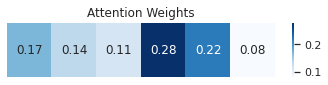

In [70]:
embedded = embedding(decoder_input)
print('\nStep %d'%(4))
print('Expected output(word) => %s '% output_sentence.split(" ")[4])
print('Expected output(Index) => %d '% target_indices[4])
# This decides the values with which output from the encoder needs weighed!
attn_weigts_layer_input = torch.cat((embedded[0], decoder_hidden[0], cell[0]), 1)
attn_weights = attn_weigts_layer(attn_weigts_layer_input)
attn_weights = F.softmax(attn_weights, dim = 1)

# This calculates the attention values!
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = lstm_inp(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm, (decoder_hidden, decoder_cell))
output = F.relu(output)

output = F.softmax(linear_out(output[0]), dim = 1)
top_value, top_index = output.data.topk(1) # same as using np.argmax
out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 6

In [71]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 5
Expected output(word) => . 
Expected output(Index) => 4 
Predicted output(word) => desk 
Predicted output(Index) => 851 


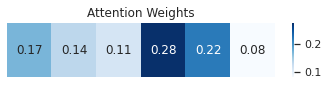

In [72]:
embedded = embedding(decoder_input)
print('\nStep %d'%(5))
print('Expected output(word) => %s '% output_sentence.split(" ")[5])
print('Expected output(Index) => %d '% target_indices[5])
# This decides the values with which output from the encoder needs weighed!
attn_weigts_layer_input = torch.cat((embedded[0], decoder_hidden[0], cell[0]), 1)
attn_weights = attn_weigts_layer(attn_weigts_layer_input)
attn_weights = F.softmax(attn_weights, dim = 1)

# This calculates the attention values!
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = lstm_inp(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm, (decoder_hidden, decoder_cell))
output = F.relu(output)

output = F.softmax(linear_out(output[0]), dim = 1)
top_value, top_index = output.data.topk(1) # same as using np.argmax
out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

## Feeding to the Decoder - Word 7

In [73]:
teacher_forcing_ratio = 0.5
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
  decoder_input = torch.tensor([[target_indices[0]]], device=device)
else:
  decoder_input = torch.tensor([[top_index.item()]], device=device)



Step 6
Expected output(word) => <EOS> 
Expected output(Index) => 1 
Predicted output(word) => desk 
Predicted output(Index) => 851 


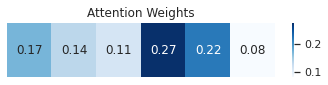

In [74]:
embedded = embedding(decoder_input)
print('\nStep %d'%(6))
print('Expected output(word) => %s '% "<EOS>")
print('Expected output(Index) => %d '% target_indices[6])
# This decides the values with which output from the encoder needs weighed!
attn_weigts_layer_input = torch.cat((embedded[0], decoder_hidden[0], cell[0]), 1)
attn_weights = attn_weigts_layer(attn_weigts_layer_input)
attn_weights = F.softmax(attn_weights, dim = 1)

# This calculates the attention values!
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = lstm_inp(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden, decoder_cell) = lstm(input_to_lstm, (decoder_hidden, decoder_cell))
output = F.relu(output)

output = F.softmax(linear_out(output[0]), dim = 1)
top_value, top_index = output.data.topk(1) # same as using np.argmax
out_word = output_lang.index2word[top_index.item()]
print('Predicted output(word) => %s '% out_word)
print('Predicted output(Index) => %d '% top_index.item())
attention_plot(attn_weights)
predicted_sentence.append(out_word)

In [75]:
predicted_sentence = ' '.join(predicted_sentence)
predicted_sentence

'depth desk desk desk desk desk desk'